# Bag of Visual Words (BoVW) & k-Nearest Neighbors for Dogs vs. Cats Classification

Using the dogs vs cats dataset collected from Kaggle, we want to try and construct a k-nearest neighbors classifier fitting it with visual vocabulary created from the data retrieved.

In [1]:
!unzip -q "/kaggle/input/dogs-vs-cats/test1.zip"
!unzip -q "/kaggle/input/dogs-vs-cats/train.zip"

Time to setup our environment.

In [2]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans

Let's specify the provided train and test directory.

In [3]:
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test1"

Given that the data is provided with two labels which are dog and cat. We store it in a list where cat should be the first index positionally as it is specified that cat is identified as 0. Whereas dog is identified as 1, so it should be the second index positionally.

In [4]:
labels = ["cat", "dog"]

Let's now check the sample size of data provided.

In [5]:
len(os.listdir(train_dir)), len(os.listdir(test_dir))

(25000, 12500)

Since there is a huge amount of data provided, we want 5000 sample of the data from the train directory to prevent expensive computing resources.

In [6]:
random.seed(21)
filenames = os.listdir(train_dir)
train_data = random.sample(filenames, 5000)
train_data[:5]

['cat.8845.jpg',
 'dog.8662.jpg',
 'dog.11525.jpg',
 'cat.4434.jpg',
 'cat.6316.jpg']

Notice how the file format contains label for the specific image. We can store them into a list.

In [7]:
train_labels = []

for filename in train_data:
    
    if filename.split(".")[0] == "dog":
        train_labels.append(1)
    elif filename.split(".")[0] == "cat":
        train_labels.append(0)
        
print(f"There are {train_labels.count(1)} dog images in the train directory.")
print(f"There are {train_labels.count(0)} cat images in the train directory.")

There are 2495 dog images in the train directory.
There are 2505 cat images in the train directory.


The sample taken for both dogs and cats is equally divided.

In [8]:
train_images = []

for filename in train_data:
    filepath = os.path.join(train_dir, filename)
    image = cv.imread(filepath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    train_images.append(image)

print(f"Loaded {len(train_images)} images from the train directory.")

Loaded 5000 images from the train directory.


Let's take a look at some of the images.

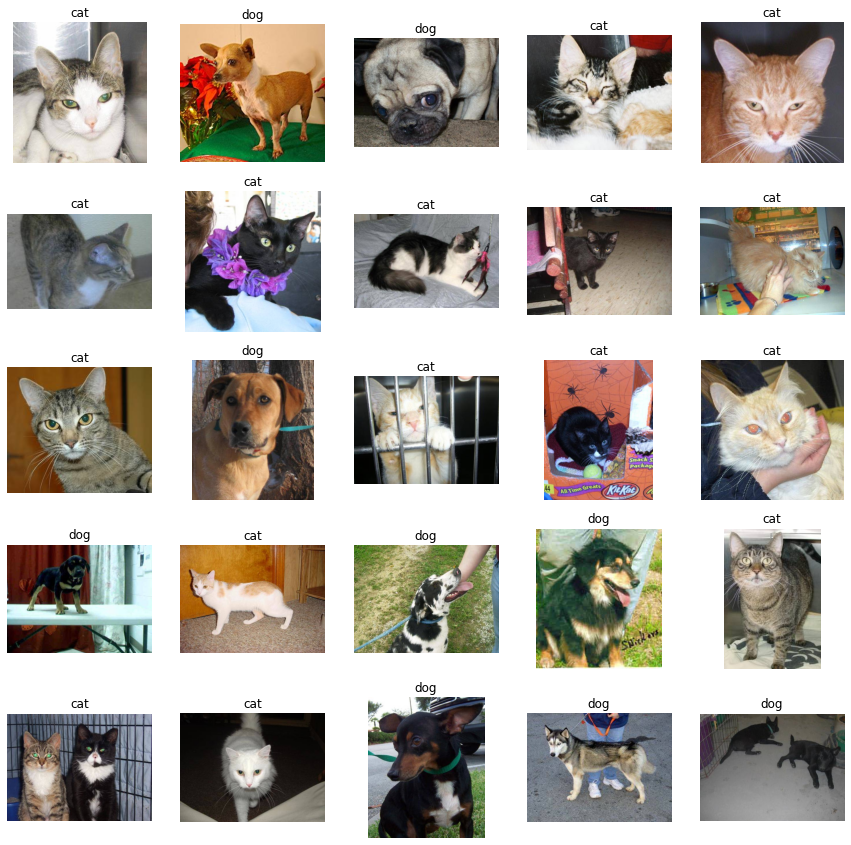

In [9]:
plt.figure(figsize=(15, 15))

index = 1

for image in train_images[:25]:
    plt.subplot(5, 5, index)
    plt.imshow(image, cmap="gray")
    plt.title(labels[train_labels[index - 1]])
    plt.axis("off")
    
    index = index + 1
    
plt.show()

We use Scale Invariant Features Transform (SIFT) to extract local feature descriptors.

In [10]:
train_descriptors = []
feature_extractor = cv.SIFT_create()

for image in train_images:
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    _, descriptors = feature_extractor.detectAndCompute(gray_image, None)
    train_descriptors.append(descriptors)
    
print(f"Extracted {len(train_descriptors)} descriptors from train data.")

Extracted 5000 descriptors from train data.


Next, we stack the descriptors for clustering purposes later on.

In [11]:
train_descriptors_stack = train_descriptors[0]

for descriptors in train_descriptors[1:]:
    train_descriptors_stack = np.vstack((train_descriptors_stack, descriptors))
    
train_descriptors_stack = train_descriptors_stack.astype("float32")
train_descriptors_stack[:5]

array([[ 21.,  36.,  51.,  14.,   4.,   0.,   0.,   2.,  18.,  15.,  33.,
          8.,  12.,  10.,  26.,  37.,   0.,   4.,  18.,   5.,   6.,  48.,
         53.,   7.,   0.,   1.,   6.,  16.,  39.,  22.,   6.,   0.,  76.,
         35.,  67.,  39.,   8.,   2.,   3.,  16., 144.,  36.,  13.,   4.,
         12.,  28.,  77., 144.,  14.,   2.,   4.,  70., 144., 141., 100.,
         31.,   0.,   0.,  16.,  96.,  77.,  25.,   4.,   0.,  59.,  10.,
          6.,   9.,  15.,   7.,  29.,  87., 144.,  42.,  18.,  51.,  25.,
          5.,   5., 101.,  23.,  10.,  16., 144., 144.,  14.,   3.,   4.,
          0.,   0.,  28., 109.,  64.,   5.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   6.,  12.,   2.,   1.,   8.,   3.,   0.,
          0.,   8.,   1.,   0.,   1.,  26.,  27.,   1.,   0.,   0.,   0.,
          0.,   1.,   7.,  20.,   3.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   0.,
          0.,   6.,   4.,   1.,   4.,   1.,   0.,   1.,  20.,

Here we retrieve the centroids from clustering with k-Means using the train descriptors.

In [13]:
centroids, _ = kmeans(train_descriptors_stack, k_or_guess=5, iter=20, seed=21)

Finally, we can compute the vectors using the previously computed centroids and extracted features.

In [14]:
train_vectors = np.zeros((len(train_images), len(centroids)), dtype="float32")

for index in range(len(train_images)):
    words, _ = vq(train_descriptors[index], centroids)
    
    for word in words:
        train_vectors[index][word] = train_vectors[index][word] + 1
        
train_vectors[:5]

array([[ 99., 126.,  84., 146., 108.],
       [ 62., 180., 108., 199., 133.],
       [236., 403., 139., 328., 461.],
       [154., 227., 171., 326., 195.],
       [118.,  67., 256., 160.,  61.]], dtype=float32)

We then normalize the values in these vectors to make it comparable to one another on the same scale.

In [15]:
train_vectors = np.array([vector / np.sum(vector) for vector in train_vectors])
train_vectors[:5]

array([[0.1758437 , 0.22380106, 0.14920071, 0.25932506, 0.19182949],
       [0.09090909, 0.2639296 , 0.15835777, 0.29178885, 0.19501466],
       [0.15060626, 0.25717932, 0.08870453, 0.20931716, 0.29419273],
       [0.14352283, 0.21155639, 0.15936626, 0.30382106, 0.18173346],
       [0.17824773, 0.10120846, 0.38670695, 0.24169184, 0.09214502]],
      dtype=float32)

We repeat the same steps for test data as well. But now, we only use 50 samples for testing our model performance at the end.

In [16]:
random.seed(21)
filenames = os.listdir(test_dir)
test_data = random.sample(filenames, 50)
test_data[:5]

['2123.jpg', '11773.jpg', '2197.jpg', '3762.jpg', '10469.jpg']

Obviously, the test data is provided without any labels.

In [17]:
test_images = []

for filename in test_data:
    image = cv.imread(os.path.join(test_dir, filename))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    test_images.append(image)
    
print(f"Loaded {len(test_images)} images from the test directory.")

Loaded 50 images from the test directory.


Let's also take a look at our test images.

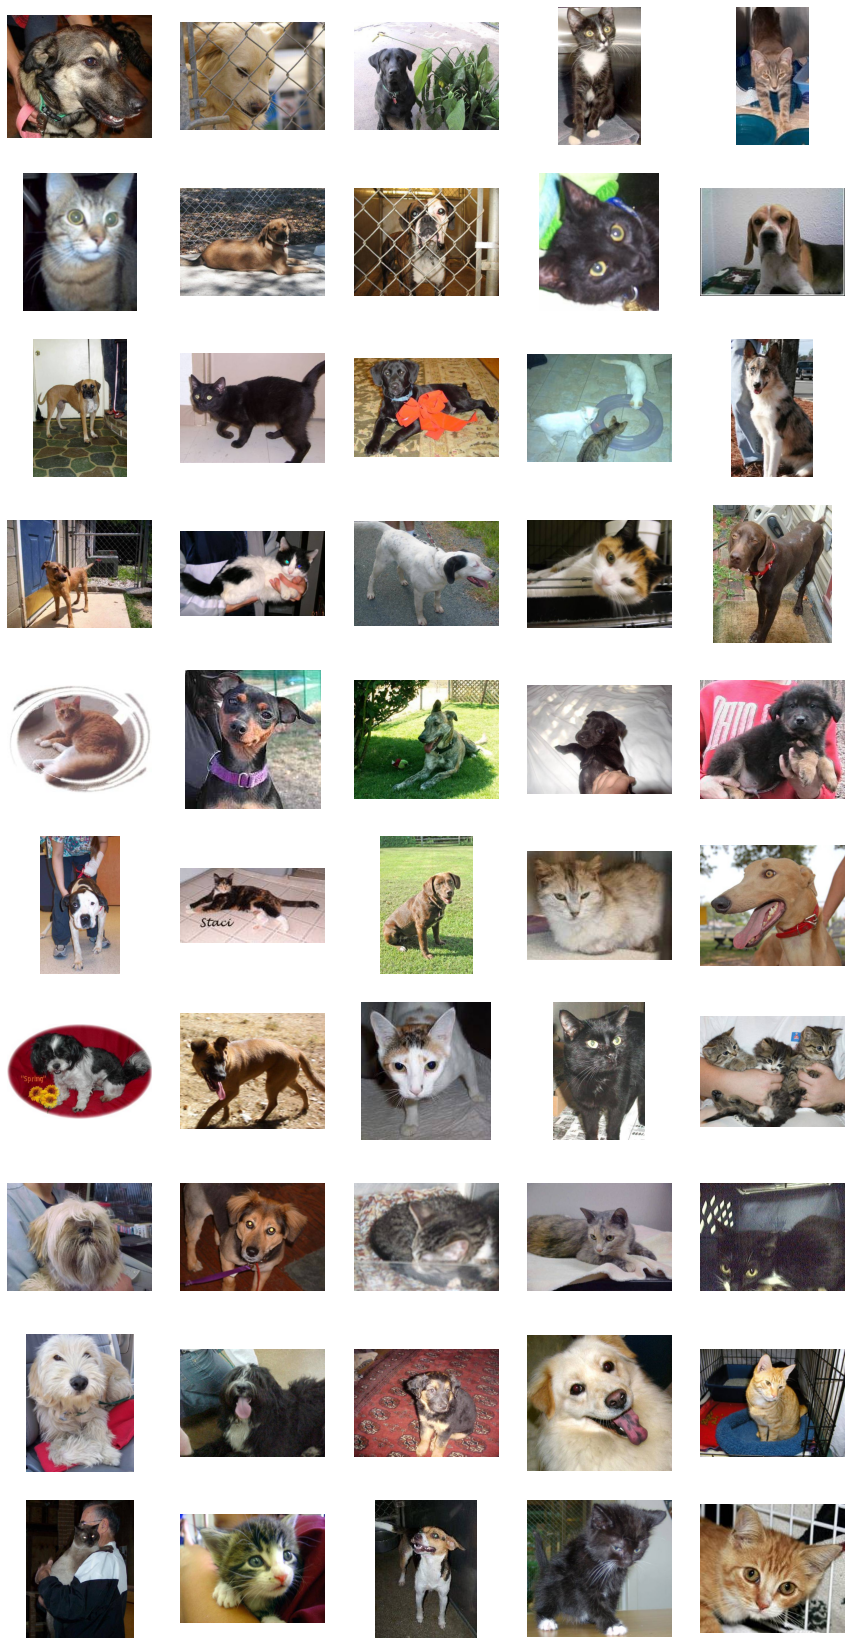

In [18]:
plt.figure(figsize=(15, 30))

index = 1

for image in test_images:
    plt.subplot(10, 5, index)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    
    index = index + 1
    
plt.show()

We can extract the local features as done before with the training data.

In [19]:
test_descriptors = []

for image in test_images:
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    _, descriptors = feature_extractor.detectAndCompute(gray_image, None)
    test_descriptors.append(descriptors)
    
print(f"Extracted {len(test_descriptors)} descriptors from test data.")

Extracted 50 descriptors from test data.


We then stack it so that it suits our purpose.

In [20]:
test_descriptors_stack = test_descriptors[0]

for descriptors in test_descriptors[1:]:
    test_descriptors_stack = np.vstack((test_descriptors_stack, descriptors))
    
test_descriptors_stack = test_descriptors_stack.astype("float32")
test_descriptors_stack[:5]

array([[ 25.,  13.,  16.,   1.,   0.,   0.,   0.,   3., 149.,   4.,   2.,
          0.,   0.,   0.,   0.,  60.,  23.,   0.,   0.,   0.,   0.,   0.,
          3.,  20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  78.,
         16.,  13.,   1.,   0.,   0.,   0.,  10., 189.,  25.,   1.,   0.,
          0.,   0.,   5., 134.,  88.,   9.,   9.,   8.,   5.,   2.,  57.,
         86.,   0.,   0.,   1.,  25.,  25.,   2.,   6.,   6.,  84.,  15.,
          5.,   1.,   0.,   0.,   4.,  12., 189., 102.,   6.,   0.,   0.,
          0.,   2.,  39.,  99.,  67.,  54.,  12.,   6.,   5.,  20.,  57.,
          3.,   2.,   7.,  26.,  43.,  55.,  50.,  17.,  53.,  10.,   1.,
          4.,   5.,   3.,   7.,   8., 189.,  68.,   3.,   0.,   0.,   0.,
          2.,  53.,  81.,  33.,  40.,  22.,   0.,   1.,  22.,  77.,   1.,
          0.,  72.,  28.,   1.,  13.,  21.,  11.],
       [ 65.,   7.,   3.,   0.,   0.,   0.,   3.,  11., 178.,  39.,   2.,
          0.,   0.,   0.,   1.,  40.,  80.,  46.,  36.,   7.,

With the resources, we can now compute the test vectors.

In [21]:
test_vectors = np.zeros((len(test_images), len(centroids)), dtype="float32")

for index in range(len(test_images)):
    words, _ = vq(test_descriptors[index], centroids)
    
    for word in words:
        test_vectors[index][word] = test_vectors[index][word] + 1
        
test_vectors[:5]

array([[158., 296., 161., 268., 280.],
       [206., 112., 166., 176., 138.],
       [204., 171., 174., 312., 176.],
       [ 89., 155., 134., 189., 154.],
       [ 20.,  49.,  31.,  66.,  41.]], dtype=float32)

We want to scale the vectors so that it is comparable to one another.

In [22]:
test_vectors = np.array([vector / np.sum(vector) for vector in test_vectors])
test_vectors[:5]

array([[0.13585554, 0.2545142 , 0.13843508, 0.23043852, 0.24075666],
       [0.25814536, 0.14035088, 0.20802005, 0.22055137, 0.17293233],
       [0.19672132, 0.16489875, 0.16779171, 0.3008679 , 0.16972035],
       [0.12343967, 0.2149792 , 0.18585297, 0.26213592, 0.21359223],
       [0.09661835, 0.23671497, 0.14975846, 0.3188406 , 0.19806764]],
      dtype=float32)

Moving on, we model the k-Neighbors Classifier.

In [23]:
from scipy.stats import mode

class KNeighborsClassifier:
    
    def __init__(self, n_neighbors, p=2):
        self.n_neighbors = n_neighbors
        self.p = p
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def get_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))
        
    def predict(self, X_test):
        y_pred = []
        for test_data in X_test:
            distances = []
            for train_data in self.X_train:
                distances.append(self.get_distance(test_data, train_data))
            distances = np.array(distances)
            sorted_distances = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[sorted_distances]
            y_pred.append(mode(neighbor_labels).mode[0])
            
        return y_pred

Having list the train data labels, we want to convert it into a numpy array so that it suits our model.

In [24]:
train_labels = np.array(train_labels)
type(train_labels)

numpy.ndarray

For modeling, we want to have three set splits of training, validation, and testing set. The training of course being 80% of the train data we used, validation being 20% of the train data we used, and testing being the 50 test data we used.

In [25]:
from sklearn.model_selection import train_test_split

train_vectors, val_vectors, train_labels, val_labels = train_test_split(train_vectors,
                                                                        train_labels,
                                                                        test_size=0.2,
                                                                        random_state=21,
                                                                        stratify=train_labels)

print(f"There are {sum(train_labels == 1)} dog images for training.")
print(f"There are {sum(train_labels == 0)} cat images for training.")
print(f"There are {sum(val_labels == 1)} dog images for validation.")
print(f"There are {sum(val_labels == 0)} cat images for validation.")

There are 1996 dog images for training.
There are 2004 cat images for training.
There are 499 dog images for validation.
There are 501 cat images for validation.


As we can see, the labels are equally spread across both training and validation data. Then, we can fit the training data into the model and predict on validation to initially take a look on its accuracy.

In [26]:
from sklearn.metrics import classification_report, accuracy_score

model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_vectors, train_labels)
val_pred = model.predict(val_vectors)

print(f"The model reaches an accuracy of {accuracy_score(val_labels, val_pred) * 100:.2f}%.")

The model reaches an accuracy of 58.00%.


It seems like the model is not well suited for this specific problem as it is not doing a convincing job of predicting on validation data. However, let's have a look at what the model predicts for every test data we used.

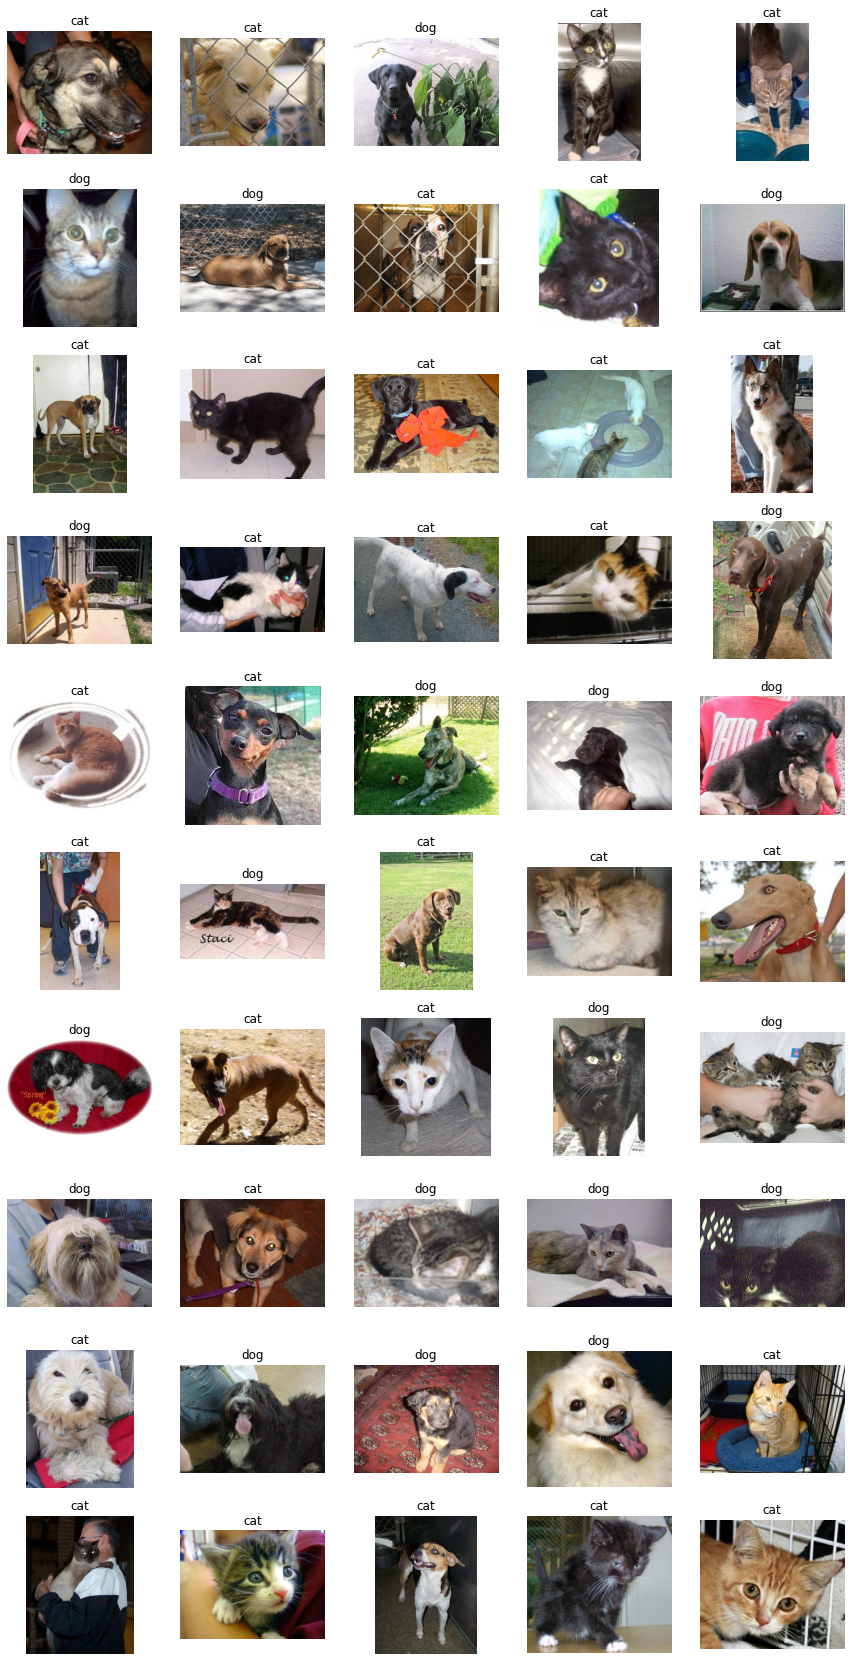

In [28]:
plt.figure(figsize=(15, 30))

index = 1
pred = model.predict(test_vectors)

for image in test_images:
    plt.subplot(10, 5, index)
    plt.imshow(image, cmap="gray")
    plt.title(labels[pred[index - 1]])
    plt.axis("off")
    
    index = index + 1
    
plt.show()

From our model predictions, it simply shows that the results is not convincing at all especially on images that are more challenging rather than an obvious visual of dogs or cats. It might be due to using visual vocabulary, which may not be the best solution to such a problem. Else, we can use more data and implement methods to set proper hyperparameters in our experiment.